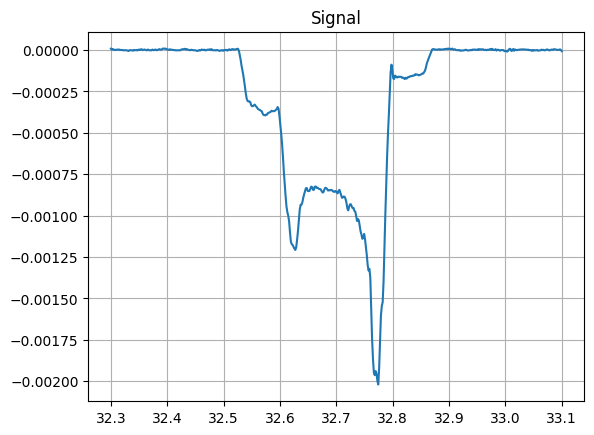

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
from scipy import optimize

signal = []
freq_list = []

# Get baseline subtracted signal to fit
with open("2_2_2023.csv","r") as file:   # This is a measured signal from RGC
    csvfile = csv.reader(file)
    for list in csvfile:
        signal.append(float(list[1]))
        freq_list.append(float(list[0]))

plt.plot(freq_list, signal)
plt.grid()
plt.title('Signal')
plt.show()

In [6]:
# This is the functional form of the Deuteron line shape.
import numpy as np

def FitFunc(w, A, G, r, wQ, wL, eta, xi):
    R = (w - wL)/(3*wQ)

    Ip, dIpdr = Iplus(r, wQ/wL, R)
    Im, dImdr = Iminus(r, wQ/wL, R)

    Fm, dFm_dR, dFm_dA, dFm_dEta = FandDerivs(R, A, -1, eta)
    Fp, dFp_dR, dFp_dA, dFp_dEta = FandDerivs(R, A, 1, eta)

    Fm /= wQ
    dFm_dR /= wQ
    dFm_dA /= wQ
    dFm_dEta /= wQ

    Fp /= wQ
    dFp_dR /= wQ
    dFp_dA /= wQ
    dFp_dEta /= wQ

    F = G * (Im*Fm + Ip*Fp)  # Lineshape
    Fm = G * (Im*Fm)  # Lineshape from minus
    Fp = G * (Ip*Fp)  # Lineshape from plus

    fAsym = 1 + 0.5 * xi * (1 + R) # False Asymmetry xi = a[7]
    dF_dXi = 0.5 * (1 + R)
    bg =  0 # background

    y = fAsym*F + bg  # total
    ym =  fAsym*Fm
    yp =  fAsym*Fp
    return y

def Iplus(r, Q, R):
    '''Returns: II, dI_dr '''
    r3QR = np.power(r, -3*Q*R)
    NN = r*(r + r3QR) + 1
    II = r*(r - r3QR)/NN
    dI_dr = (2*r*(1-II)-(1-3*Q*R)*r3QR*(1+II))/NN
    return II, dI_dr

def Iminus(r, Q, R):
    '''Returns: II, dI_dr '''
    r3QR = np.power(r, 3*Q*R)
    NN = r*(r + r3QR) + 1
    II = (r*r3QR - 1)/ NN
    dI_dr = ((1+3*Q*R)*r3QR*(1-II)-2*r*II)/NN
    return II, dI_dr

def Integrals( R, A, eps, Y2, etac2p):
    ''' Returns: ans1, ans2, ans3, ans4'''
    Y = np.sqrt(Y2)
    Yx2 = 2*Y
    z2 = 1 - eps*R - etac2p
    A2 = A*A
    q4 = z2*z2 + A2
    q2 = np.sqrt(q4)
    qq = np.sqrt(q2)

    cosa = z2/q2
    cosa_2 = 1/np.sqrt(2) * np.sqrt(1+cosa)
    sina_2 = 1/np.sqrt(2) * np.sqrt(1-cosa)

    fTmp = Y2+q2
    fVal = Yx2*qq*cosa_2

    La  = 0.5 * sina_2 * np.log( (fTmp + fVal) / (fTmp - fVal) )
    Ta  = cosa_2 * (np.pi/2 + np.arctan( ( Y2-q2) / (Yx2 * qq * sina_2) ) )
    Arg = (Y2 * (Y2 - 2*z2)  + q4 )

    ans1 = (Ta + La) / (2 * qq * A)
    ans2 = (Ta - La) * qq / (2 * A)
    ans3 = z2*(ans2) + (2*A2 + q4) * (ans1) + (Y/Arg) * (Y2*z2 + 2*A2 - q4)
    ans4 = ((Y/Arg)*(Y2 - z2) + z2*(ans1) + (ans2))/(4 * A2)

    return ans1, ans2, ans3, ans4

def FandDerivs(R, A, eps, eta):
    '''Returns FF, dFdA, dFdR, dFdEta'''
    if eta < 0.001:
        Y2 = 3
        I1, I2, I3, I4 = Integrals(R, A, eps, Y2, 0)
        FF = I1*A
        dFdA = (I1 - 2.0 * A*A * I3 )
        dFdR = ( (1 - eps * R) * I3 - I4 ) * 2 * A * eps
        dFdEta = 0
    else:
        Y2 = 3
        I1, I2, I3, I4 = Integrals(R, A, eps, Y2, 0)
        FF, dFdA, dFdR, dFdEta = (0,0,0,0)
        eRm1 = 1 - eps*R
        dphi = 1

        for i in (0,1):
            c2p = np.cos(np.pi*dphi*i)
            ec2p = eta*c2p
            Y2 = 3 - ec2p
            Y = np.sqrt(Y2)
            z2 = eRm1 - ec2p

            I1, I2, I3, I4 = Integrals(R, A, eps, Y2, 0)

            fac = 0.5 * np.sqrt(3) / Y
            FF += fac * I1 * A

            dFdA += fac * (I1 - 2 * A*A * I3 )
            dFdR += fac*( z2*I3 - I4 )*2*A*eps
            gY =  Y2 * (Y2 - 2*z2) + A*A + z2*z2
            dFdEta += 2*A*c2p*fac * (z2*I3 - I4 + I1/(4*Y2) - 1/(4*Y*gY))

        order = 5
        for N in [np.power(2,n) for n in range(2,order+1)]:
            dphi = 1/N

            for i in range(N-1, 0, -2):
                c2p = np.cos(np.pi*dphi*i)
                ec2p = eta*c2p

                Y2 = 3 - ec2p
                Y = np.sqrt(Y2)
                z2 = eRm1 - ec2p

                I1, I2, I3, I4 = Integrals(R, A, eps, Y2, ec2p)

                fac = np.sqrt(3)/Y

                FF += fac*I1*A

                dFdA += fac*(I1 - 2*A*A*I3)
                dFdR += fac*(z2*I3 - I4)*2*A*eps
                gY = Y2 * (Y2 - 2*z2) + A*A + z2*z2
                dFdEta += 2*A*c2p*fac * (z2*I3 - I4 + I1/(4*Y2) - 1/(4*Y*gY))


        FF = dphi*FF
        dFdA = dphi*dFdA
        dFdR = dphi*dFdR
        dFdEta = dphi*dFdEta

    return FF, dFdA, dFdR, dFdEta


Polarization: 40.09216589861751 %


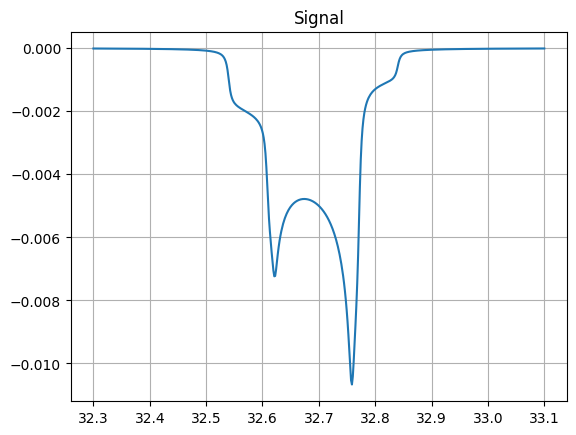

Area: -0.8041411936704925


In [7]:
# This plots a nominal D lineshape to let you play with the 7 parameters.
import numpy as np
import matplotlib.pyplot as plt

# All translated by J. Maxwell from C program by Chris Dulya

A = 0.05
G = -2e-04
r = 1.9
wQ = 0.025
wL = 32.69
eta = 8.989946e-02
xi = -.0021


f = np.linspace(32.3,33.1,512)

pol = (r*r-1)/(r*r + r +1)
print("Polarization:", pol*100, "%")


plt.plot(f, FitFunc(f, A, G, r, wQ, wL, eta, xi))
plt.grid()
plt.title('Signal')
plt.show()
print("Area:",FitFunc(f, A, G, r, wQ, wL, eta, xi).sum())
